# TIMESERIES ANOMALY DETECTION
## AUTHOR: ANTE DUJIC
<hr style="border:2px solid gray"> </hr>

<center><img src="https://i0.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1200%2C800&ssl=1" width="400"/></center>

The aim of this notebook is to break down and explain in details the code from [Keras documentation](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) on Timeseries anomaly detection using an Autoencoder.

<hr style="border:2px solid gray"> </hr>

## INTRODUCTION
***

**Time series** is a collection of data points gathered over time intervals (miliseconds, days, years, etc.) that allow us to track changes over time. [22] Detecting anomalies in a time series data is an important task in many areas, from manucfacturing processes, over heath care to finance application or cybersecurity. [23] Depending on the specific case and application, anomalies only typically occur 0.001-1% of the time. [24] **Anomaly detection**, sometimes referred to as outlier detection, involves identifying the differences, deviations, and exceptions from the norm in a time series. [1] To detect anomalies, data scientists have developed various specialised algorithms. Detecting anomalies in essence a complicated task, but Keras offers high level abstraction and provides the user with simple enough tools to solve the problem.

**Keras** is deep learning API developed by Google for implementing neural networks. [3] It makes the implementation of the neural networks easier.

> *Keras is: [2]*
> - *Simple -- but not simplistic. Keras reduces developer cognitive load to free you to focus on the parts of the problem that really matter.*
> - *Flexible -- Keras adopts the principle of progressive disclosure of complexity: simple workflows should be quick and easy, while arbitrarily advanced workflows should be possible via a clear path that builds upon what you've already learned.*
> - *Powerful -- Keras provides industry-strength performance and scalability: it is used by organizations and companies including NASA, YouTube, or Waymo.*

Keras is written in Python and it is running on top of the machine learning platform Tenserflow. Tenserflow is an open-source software library for machine learning and artificial intelligence developed by Google Brain Team. [4] As the documentation title suggests, Keras uses autoencoder for the anomaly detection.

An **autoencoder** is a type of artificial neural network where the input is the same as the output. It works by compressing the input into a lower-dimensional code using encoder and then reconstructing the output from this lower-dimensional representation using decoder. [5]

***

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## DATA
***

There are two datasets used for the anomaly detection, as per Keras documentation - [Numenta Anomaly Benchmark(NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab) datasets. NAB provide a controlled and repeatable environment of open-source tools for evaluating real-time anomaly detection algorithms on streaming data. [6] It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. [7] Majority of data is real-world, but ones used are artificially generated. Data used for the anomaly detection can be found in the [GitHub](https://github.com/numenta/NAB/tree/master/data) repository, in the *data* folder. The simplicity of this dataset allows the effective demonstration of anomaly detection.

```
NAB 
│
└───data
│   │
│   └───artificialNoAnomaly
│   │    │   art_daily_small_noise.csv
│   │    │   ...
│   │
│   └───artificialWithAnomaly
│   │    │   art_daily_jumpsup.csv
│   │    │   ...
│   │
│   └─── ...
│
└─── ...
```

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

#### TIMESERIES DATA WITHOUT ANOMALIES
***

As the name of this dataset suggests, it is artificially-generated data <u>without anomalies</u>. This dataset will be used for training. We'll have a look at this dataset below.

In [5]:
# Read data into a dataframe, setting "timestamp" as the index column
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# First 5 records of the dataset
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


Looking at the output above, and comparing the values from the direct url, we see that the values get rounded. <br>
<br> 18.324918539200002 &rarr; 18.324919
<br> 21.970327182 &rarr; 21.970327

We can extract the data, to confirm the rounding.

In [7]:
# Double check the first value, to see if and how the value was round.
df_small_noise.iloc[0]['value']

18.3249185392

In [8]:
# Double check the first value, to see if and how the value was round.
df_small_noise.iloc[1]['value']

21.970327182

The rounding from in the *head* output is only visual, but we see that some values still get rounded to a certain degree.<br>
<br> 18.324918539200002 &rarr; 18.3249185392
<br> 21.970327182 &rarr; 21.970327182

This rounding is deemed insignificant.

In [9]:
# Overall summary of the dataset (number of values, mean, std, etc.)
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


We can see there are 4032 records in this dataset. We can also see the mean, standard deviation, the min and max values and the 25th, 50th, and 75th percentiles.

Below is the dataset plotted. It gives a better insight to the dataset.

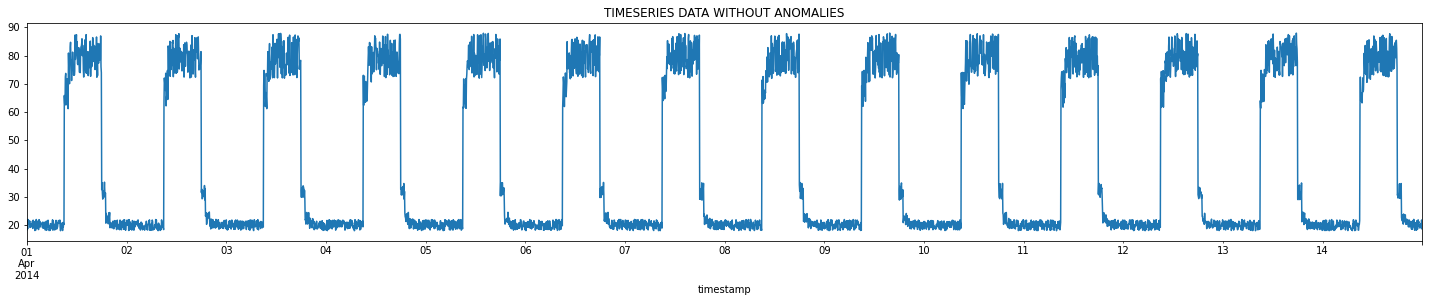

In [10]:
# Plot size.
fig, ax = plt.subplots(figsize=(25,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax)
# Name the plot.
plt.title("TIMESERIES DATA WITHOUT ANOMALIES");

#### TIMESERIES DATA WITH ANOMALIES
***

Same as the above data, the name suggests this dataset is artificially-generated data <u>with anomalies</u>. This will be best visible when data is visualised. This dataset will be used for testing. We'll have a look at this dataset below.

In [11]:
# Read data into a dataframe, setting "timestamp" as the index column
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [12]:
# First 5 recordds of the dataset
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [13]:
# Double check the first value, to see if and how the value was round.
df_daily_jumpsup.iloc[0]['value']

19.761251903

Same as with data without anomalies, this data also gets rounded but insignificantly.

In [14]:
# # Overall summary of the dataset (number of values, mean, std, etc.)
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


There are also 4032 records in this dataset. We can also see the mean, standard deviation, the min and max values and the 25th, 50th and 75th percentiles. Below is the visualisation of the data. It is clearly visible how this dataset contains anomaly.

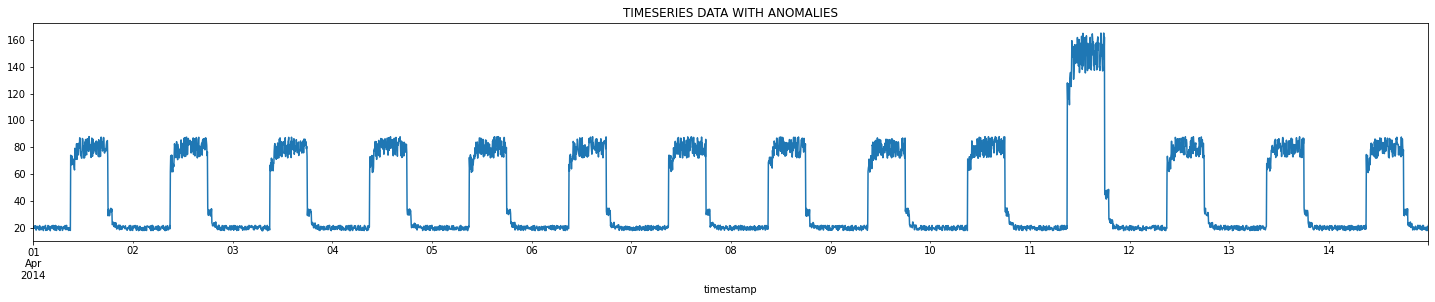

In [15]:
# Plot size
fig, ax = plt.subplots(figsize=(25,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);
plt.title("TIMESERIES DATA WITH ANOMALIES");

#### OVERVIEW

In [16]:
# No anomaly dataset details
no_anomaly = df_small_noise.describe()
# No anomaly dataset details
with_anomaly = df_daily_jumpsup.describe() 
# Combined details
result = pd.concat([no_anomaly, with_anomaly], axis=1, keys=["NO ANOMALY", "WITH ANOMALY"])
result

,NO ANOMALY,WITH ANOMALY
,value,value
count,4032.000000,4032.000000
mean,42.438353,44.494254
std,28.077122,32.432473
min,18.000964,18.001010
25%,19.841390,19.991382
50%,21.608487,21.648503
75%,75.450282,76.435943
max,87.976128,164.947481


Having the two dataset information lined next to eachother allow us to see the difference in the mean and standard deviation. We can also see a very high difference in the maximum value. This will have an impact on how we'll prepare those datasets.

### PREPROCESSING
***

Data **preprocessing** is the first step in machine learning and involves  preparing the raw data and making it suitable for a machine learning model. It is a crucial step in machine learning. [25]

We have established above that the range of the two datasets defer. The *No-anomaly* dataset ranges from ~ 18 to ~ 88, while *With anomaly* dataset ranges form ~18 to ~165. Whenever the attributes of the dataset have different ranges, it is recommended to use the normalisation or standardisation. It helps to enhance the performance and reliability of the machine learning model. [8] A good rule of thumb is that input variables should be small values, probably in the range of 0-1 or standardized with a zero mean and a standard deviation of one. [9] To standardize the dataset we'll use the formula below: [10]

###  $$ z = {X - \mu \over \sigma} $$

- z - standardized value
- X - value we calculate the z for
- $\mu$ - mean
- $\sigma$ - standard deviation

In [17]:
# Get training dataset mean
train_mean = df_small_noise.mean()
train_mean[0]

42.438353335806646

In [18]:
# Get training dataset standard deviation
train_std = df_small_noise.std()
train_std[0]

28.077122281262515

The idea is to take the value column and create a new df - Values that are equivalent to the original values, but with the mean of 0 and std of 1. That's done to standardize the effect.

In [19]:
# Calculate standardized value using the above formula
df_train_vals = (df_small_noise - train_mean) / train_std

In [20]:
# # First 5 records of the standardized dataset
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [21]:
# Create a column with the standardized data
df_small_noise['standardized'] = df_train_vals

In [22]:
# Get the mean and std of the standardized data
# The idea was to get the new dataset with mean of 0 and std of 1
df_small_noise['standardized'].mean(), df_small_noise['standardized'].std()

(-2.616541242931684e-15, 1.0000000000000018)

In [23]:
# Round the data to see that we indeed got the wanted mean and std
round(df_small_noise['standardized'].mean()), round(df_small_noise['standardized'].std())

(0, 1)

We can see above that the mean of the standardized dataset is ~ 0, and the standard deviation is ~ 1.

In [24]:
# # First 5 records of original and standardized dataset
df_small_noise.head()

,value,standardized
timestamp,,
2014-04-01 00:00:00,18.324919,-0.858829
2014-04-01 00:05:00,21.970327,-0.728993
2014-04-01 00:10:00,18.624806,-0.848148
2014-04-01 00:15:00,21.953684,-0.729586
2014-04-01 00:20:00,21.909120,-0.731173


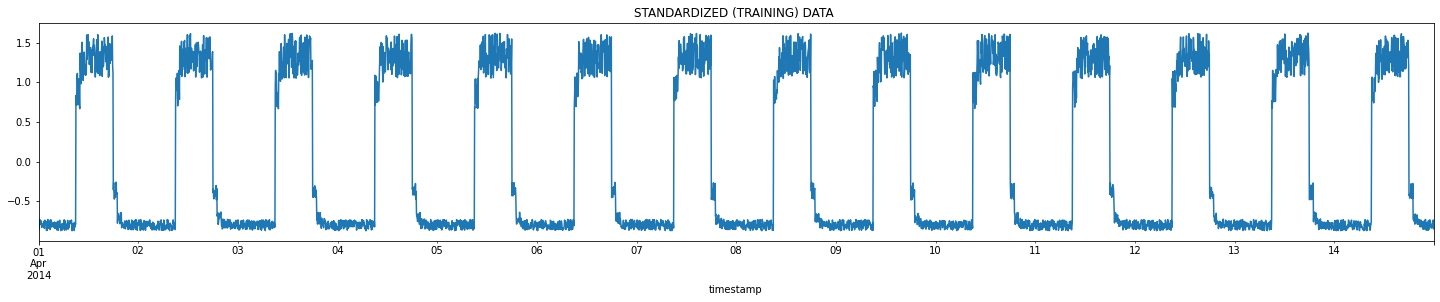

In [25]:
# Plot size
fig, ax = plt.subplots(figsize=(25,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);
plt.title("STANDARDIZED (TRAINING) DATA ");

In [26]:
print("Number of training samples:", len(df_train_vals))

Number of training samples: 4032


##### WINDOW SLIDING

In order to detect anomalous points in time series, a sliding window technique is one of the powerful method due to its applicability for a real-time detection. [11] The sliding window method is useful for reducing the time complexity of certain problems. [12] When used for preprocessing time-series data, it provides an improvement in accuracy, latency, and cost of processing. A sliding window set is a way to restructure a time series dataset as a supervised learning problem. Once restructured, the data works as an input to the artificial intelligence model.

<center><img src="img/window.drawio.svg" width="500"/></center>

In [27]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [28]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [29]:
# Remove brackets.
len(L) - win_size + 1

10

In [30]:
# For accumulating the windows.
wins = []
# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

In [31]:
# Create a 2D numpy array from wins.
wins = np.stack(wins)
wins

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [32]:
wins.shape

(10, 3)

We'll apply the above window sliding technique to our training dataset. There is a value for every 5 min for 14 days in the dataset. If we divide the total number of records (4032) with the number of days (14) we get 288 timesteps per day. This is deemed the good size for the window.

In [33]:
# Window size for our training dataset 
window_size = 288

In [34]:
# Number of windows
len(df_train_vals) - window_size + 1

3745

In [35]:
# Function to generate training sequences for use in the model
def create_sequences(values, time_steps=window_size):
    # Empty list
    windows = []
    # Loop through all the possible windows
    for i in range(len(values) - time_steps + 1):
        # Append the window to the list
        windows.append(values[i : (i + time_steps)])
    # Stack the result
    return np.stack(windows)

In [36]:
# Apply the function to the training dataset (create sequences)
x_train = create_sequences(df_train_vals)

In [37]:
# Get the shape of the array
x_train.shape

(3745, 288, 1)

We can see there are 3745 windows, each of size 288.

In [38]:
# First window (sequence) (1 day)
x_train[0].shape

(288, 1)

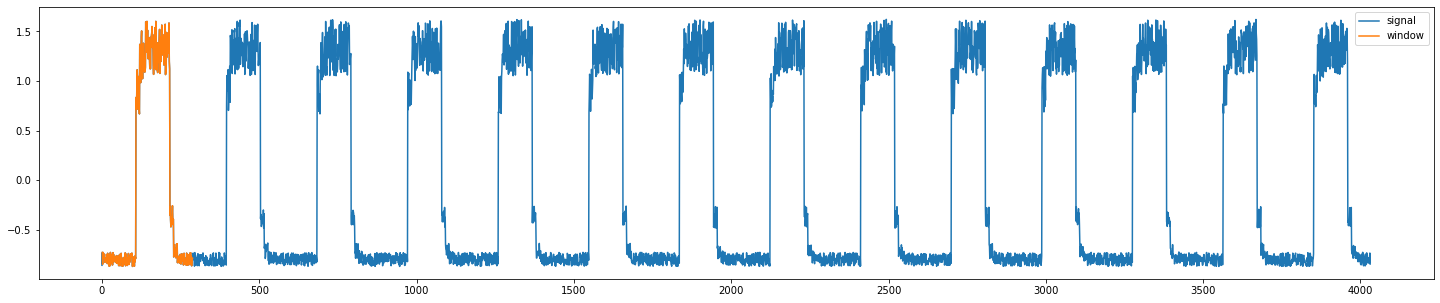

In [39]:
# Define the window number
window_no = 1

# Plot size
fig, ax = plt.subplots(figsize=(25, 5))
# Plot the dataset
ax.plot(np.arange(df_train_vals.shape[0]), df_train_vals, label='signal')
# The first window
w = x_train[window_no].flatten()
# Plot the window
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')
ax.legend();


### BUILD A MODEL
***

A typical model in Keras is an aggregate of multiple training and inferential layers. [15] Keras Layers are the functional building blocks of Keras Models. Each layer is created using numerous layer_() functions. These layers are fed with input information, they process this information, do some computation and hence produce the output. Further, this output of one layer is fed to another layer as its input. [17] There are two methods to build models in Keras:
1. Functional -  handles non-linear models with diverse functionalities.
2. Sequential - used in a network that has a linear topology.

To build our model we use the Sequential class in Keras allowing us to group a linear stack of layers into the model. Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer. Each layer has weights that correspond to the layer that follows it. [13] Generally, all layers in Keras need to know the shape of their inputs in order to be able to create their weights. So when you create a layer like this, initially, it has no weights. It creates its weights the first time it is called on an input, since the shape of the weights depends on the shape of the inputs. This also applies to Sequential models. In general, it's a recommended to always specify the input shape of a Sequential model in advance if you know what it is. This can be done by passing an [Input](https://keras.io/api/layers/core_layers/input/) object to your model, so that it knows its input shape from the start. The input object is not a layer. [16]

In [40]:
# Input shape
x_train.shape[1], x_train.shape[2]

(288, 1)

In [41]:
# Create sequential model (layers will be added to this below)
model = keras.Sequential()

In [42]:
# Pass the input object
model.add(keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])))

<br>

There is a variaty of layers available to choose from in [Keras](https://keras.io/api/layers/), each with specific task. It is also possible to create own layers. There are no rules about which layers have to be used for a certain task, or how many. It is up to the user to research, experiment or copy the other existing work. Layers used for this anomaly detection are two of the Convolutional type ([Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/), [Conv1DTranspose](https://keras.io/api/layers/convolution_layers/convolution1d_transpose/)) and the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/).

The first layer added to our model is  of the Convolutional type - [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/). Convolution is a mathematical operation on two functions that produces a third function that expresses how the shape of one is modified by the other. [19] Research has shown that using convultion for time series classification has several important advantages over other methods. They are highly noise-resistant models, and they are able to extract very informative, deep features, which are independent from time. [18] The following layer is the  [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer. The main purpose of dropout layer is to remove the noise that may be present in the input of neurons. This consequently prevents over-fitting of model. The third layer type used in the model belongs to the Convolutional Type too, but is in essence the Deconvolutional. It is the proccess inverse to convolution. It is used when we want the transformation direction to go from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution. [20)
<br>

$ LAYERS: Conv1D \Rightarrow Dropout \Rightarrow Conv1D \Rightarrow Conv1DTranspose \Rightarrow  Dropout \Rightarrow Conv1DTranspose \Rightarrow Conv1DTranspose $

In [43]:
# First layer: Conv1D
model.add(keras.layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))

In [44]:
# Second layer: Dropout
model.add(keras.layers.Dropout(rate=0.2))

In [45]:
# Third layer: Conv1D
model.add(keras.layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))

In [46]:
# Fourth layer: Conv1DTranspose
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))

In [47]:
# Fifth layer: Dropout
model.add(keras.layers.Dropout(rate=0.2))

In [48]:
# Sixth layer: Conv1DTranspose
model.add(keras.layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))

In [49]:
# Seventh (final) layer: Conv1DTranspose
model.add(keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"))

In [50]:
# Looking at the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

The above output gives us the breakdown off all the layers used, their output and the number of parameters. We can also see the total number of parameters used in the model.

Finally, we need to compile our model. Compiling the model takes two parameters: optimizer and loss. The optimizer is used to control the learning rate. The optimizer we will use is the "adam" optimizer. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. [21] Adam is a good optimizer for general purpose. It adjusts the learning rate throughout training. The learning rate determines how fast the optimal weights for the model are calculated. A smaller learning rate may lead to more accurate weights, but the time it takes to compute the weights will be longer. [13] For our loss function, we will use ‘mse - mean_squared_error’. It is the average squared difference between the estimated(predicted) values and the actual value. It is a popular loss function for regression problems. The closer to 0 this is, the better the model performed.

In [51]:
# Defining the optimizer (for compiling) 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [52]:
# Compiling the model (final step)
model.compile(optimizer=optimizer, loss="mse")

### TRAIN THE MODEL
***

Next step is to train the above built model. This is done using [*fit()*](https://keras.io/api/models/model_training_apis/) function. This function trains the model for a fixed number of epochs. Number of epochs is the number of times the model will cycle through the data. Model will improve with each epoch run, up to a certain point. We use [*EarlyStopping*](https://keras.io/api/callbacks/early_stopping/) to stop the training when the model stops improving. Please note that the number of epochs in Keras documentation is 50. The number of cycles in documentation stops on 15, but when recreated it keeps running to the end. Therefore, the epochs number has been increased to 100, to allow model more cycles to get improved. *fit* function takes *x_train* as both input and the target because this is a reconstruction model. It returns an object with records of training loss values and validation loss values (see the output below).

In [53]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
27/27 [==============================] - 2s 64ms/step - loss: 0.5463 - val_loss: 0.0830
Epoch 2/100
27/27 [==============================] - 1s 53ms/step - loss: 0.0817 - val_loss: 0.0389
Epoch 3/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0585 - val_loss: 0.0330
Epoch 4/100
27/27 [==============================] - 2s 61ms/step - loss: 0.0499 - val_loss: 0.0297
Epoch 5/100
27/27 [==============================] - 2s 61ms/step - loss: 0.0443 - val_loss: 0.0275
Epoch 6/100
27/27 [==============================] - 2s 62ms/step - loss: 0.0399 - val_loss: 0.0260
Epoch 7/100
27/27 [==============================] - 2s 60ms/step - loss: 0.0366 - val_loss: 0.0244
Epoch 8/100
27/27 [==============================] - 2s 61ms/step - loss: 0.0336 - val_loss: 0.0224
Epoch 9/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0311 - val_loss: 0.0214
Epoch 10/100
27/27 [==============================] - 2s 60ms/step - loss: 0.0288 - val_loss: 0.0207

In [54]:
# Get history keys
for key, values in history.history.items() :
    print (key)

loss
val_loss


In [55]:
# Training loss values (first 10)
history.history["loss"][0:10]

[0.546292781829834,
 0.08172135800123215,
 0.05851396918296814,
 0.04990002512931824,
 0.04425395280122757,
 0.03992687910795212,
 0.03656404837965965,
 0.03362695127725601,
 0.031072476878762245,
 0.028833329677581787]

In [56]:
# Validation loss values (first 10)
history.history["val_loss"][0:10]

[0.08298557251691818,
 0.03885665535926819,
 0.032970622181892395,
 0.029676055535674095,
 0.027508364990353584,
 0.026023121550679207,
 0.024401221424341202,
 0.022407902404665947,
 0.021406466141343117,
 0.020650409162044525]

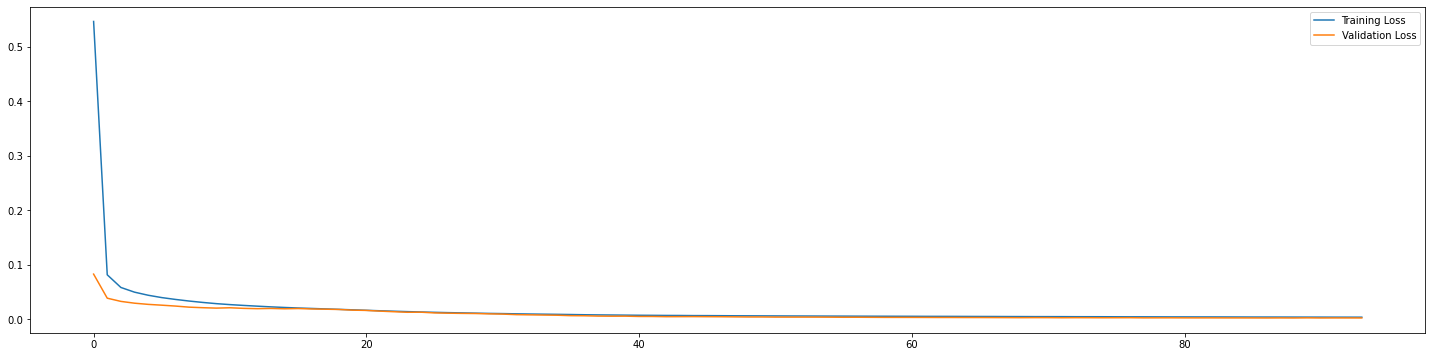

In [57]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 6))
# Plot training loss values
ax.plot(history.history["loss"], label="Training Loss")
# Plot validation loss values
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

The x-axis is the number of epochs, and the y-axis is the loss. We can cofirm from the plot that both loss values get improved over time. The improvement is significant at the start and gets slower, until it eventually stops.

### ANOMALY DETECTION
***

To detect the anomalies we need to first determine how well our model can reconstruct the input data. Then we calculate the loss value between actual and reconstruction using mean absolute error. After that, a threshold is set to identify the outliers (anomalies). If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [58]:
# Get predicted data
x_train_pred = model.predict(x_train)

118/118 [==============================] - 2s 11ms/step


In [59]:
# Get the mean absolute error between actual and prediction/reconstruction
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [60]:
# Get reconstruction loss threshold - maximum value of the loss array
threshold = np.max(train_mae_loss)
threshold

0.047167731948000925

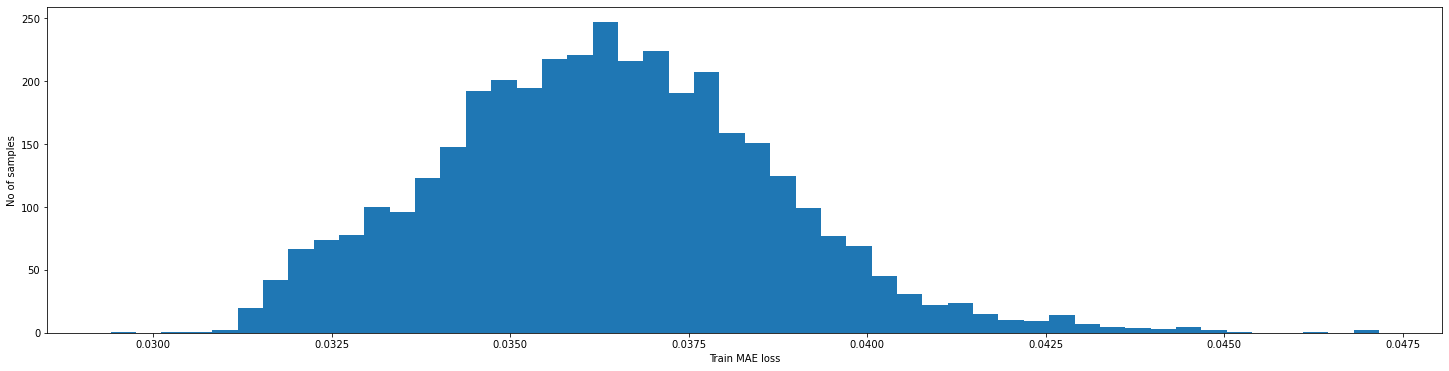

In [61]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 6))
# Plot losses
ax.hist(train_mae_loss, bins=50)
ax.set_xlabel("Train MAE loss")
ax.set_ylabel("No of samples");

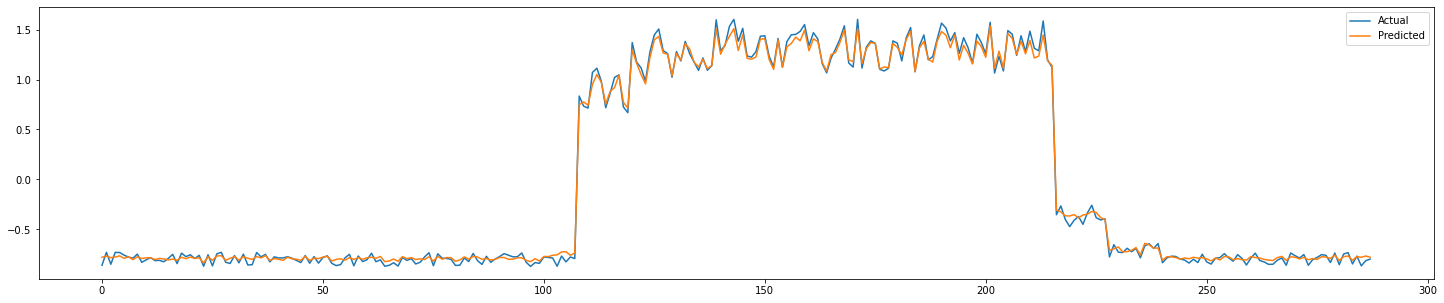

In [62]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 5))
# Plot actual (first sequence)
ax.plot(x_train[0], label="Actual")
# Plot predicted (first sequence)
ax.plot(x_train_pred[0], label="Predicted")
plt.legend();

We will now apply the same action/calculations on the testing dataset that were done on the training dataset. First, we'll standardize the dataset. This has to be done using the same values as with the training dataset, therefore mean and standard deviation of the training dataset is used.

In [63]:
# Standardize the dataset
df_test_value = (df_daily_jumpsup - train_mean) / train_std

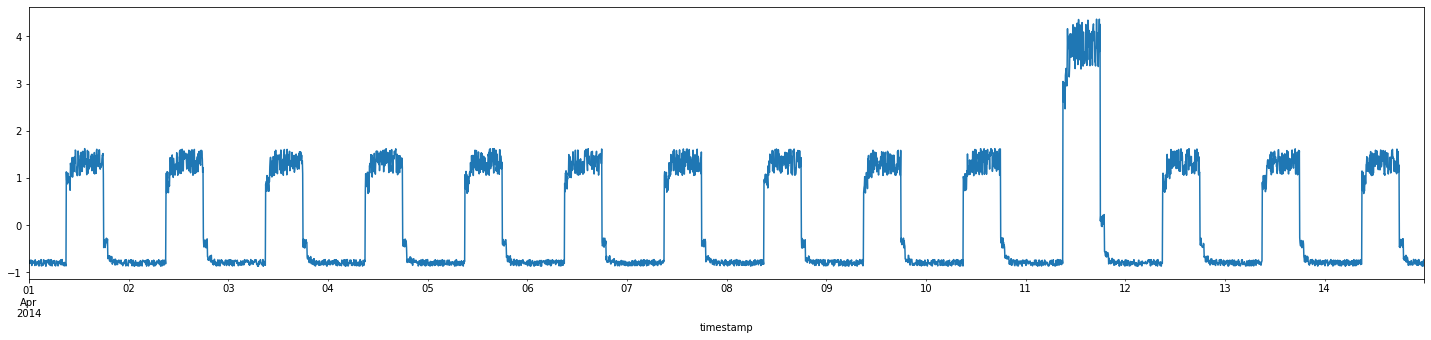

In [64]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 5))

# Plot standardized testing dataset
df_test_value.plot(legend=False, ax=ax);

In [65]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [66]:
# Get predicted sequenced data
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 11ms/step


In [67]:
# Calculate MAE for predictions
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss

array([[0.03633949],
       [0.0397755 ],
       [0.03840128],
       ...,
       [0.0359771 ],
       [0.03758727],
       [0.03801988]])

In [68]:
# Reshape for plotting
test_mae_loss = test_mae_loss.reshape((-1))

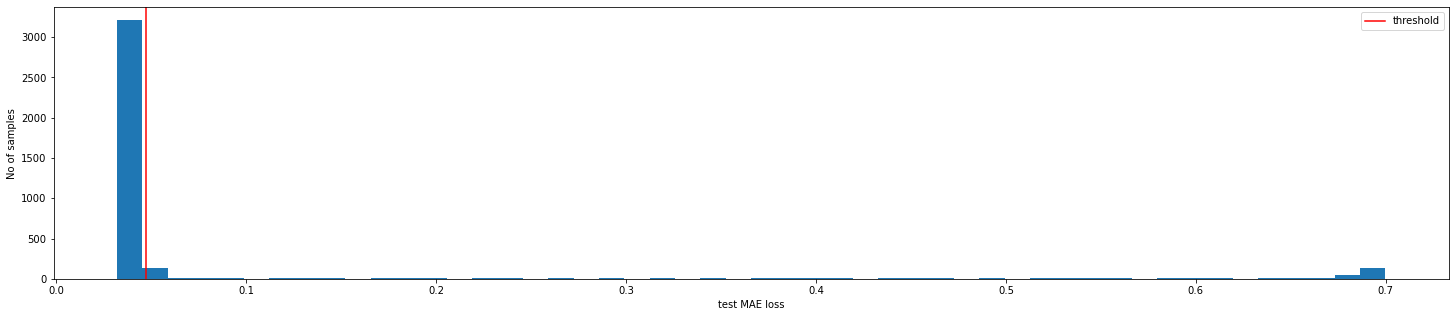

In [69]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 5))
# Plot losses
plt.axvline(x = threshold, color = 'red', label = 'threshold')
ax.hist(test_mae_loss, bins=50) 
ax.set_xlabel("test MAE loss")
ax.set_ylabel("No of samples")
plt.legend();

In [70]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

In [71]:
print("Number of anomaly samples: ", np.sum(anomalies))

Number of anomaly samples:  422


In [72]:
# Data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

# Loop
for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [73]:
# New dataset of anomaly values
df_subset = df_daily_jumpsup.iloc[inds]
df_subset

,value
timestamp,
2014-04-11 09:00:00,127.882020
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
...,...
2014-04-11 18:15:00,41.887393
2014-04-11 18:20:00,42.121161
2014-04-11 18:25:00,41.591018


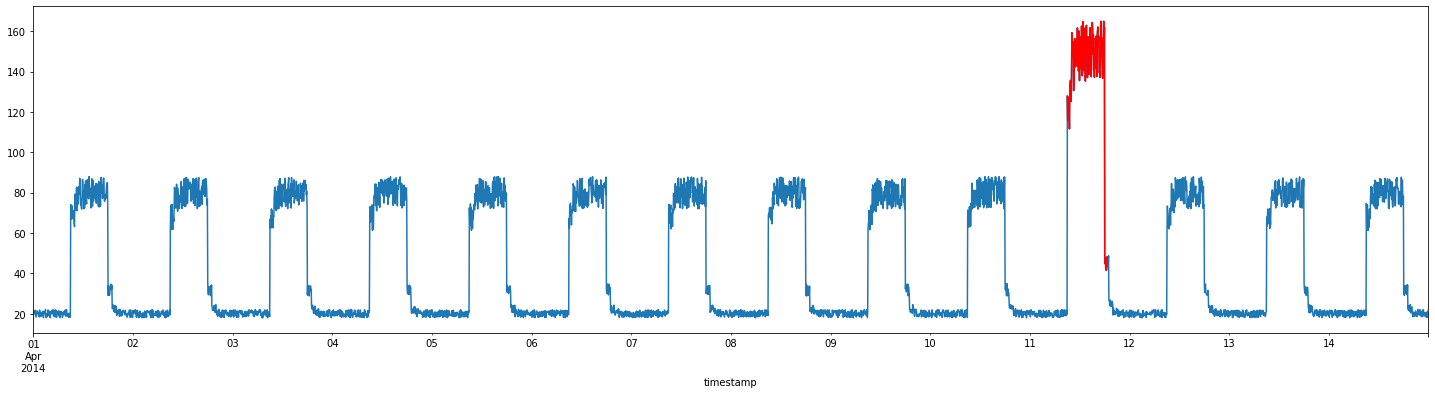

In [74]:
# Plot size
fig, ax = plt.subplots(figsize=(25, 6))

# Plot the full anomally dataset
df_daily_jumpsup.plot(legend=False, ax=ax)

# Overlay the data that fit into anomaly conditions
df_subset.plot(legend=False, ax=ax, color="r");

### REFERENCES

1. https://thedatascientist.com/anomaly-detection-why-you-need-it/
2. https://keras.io/about/
3. https://www.simplilearn.com/tutorials/deep-learning-tutorial/what-is-keras
4. https://en.wikipedia.org/wiki/TensorFlow
5. https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
6. https://www.kaggle.com/datasets/boltzmannbrain/nab
7. https://paperswithcode.com/dataset/nab
8. https://www.javatpoint.com/normalization-in-machine-learning
9. https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
10. https://www.statisticshowto.com/standardized-values-examples/
11. https://www.researchgate.net/publication/353001246_Anomaly_Detection_Using_a_Sliding_Window_Technique_and_Data_Imputation_with_Machine_Learning_for_Hydrological_Time_Series
12. https://programmathically.com/what-is-the-sliding-window-algorithm/
13. https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37
14. https://github.com/knathanieltucker/a-bit-of-deep-learning-and-keras/blob/master/notebooks/Sequential.ipynb
15. https://www.geeksforgeeks.org/how-to-create-models-in-keras/
16. https://keras.io/guides/sequential_model/
17. https://techvidvan.com/tutorials/keras-layers/
18. https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
19. https://en.wikipedia.org/wiki/Convolution
20. https://keras.io/api/layers/convolution_layers/convolution1d_transpose/
21. https://arxiv.org/abs/1412.6980
22. https://www.timescale.com/blog/time-series-data/
23. https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf
24. https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/
25. https://www.javatpoint.com/data-preprocessing-machine-learning

https://towardsdatascience.com/fraud-and-anomaly-detection-with-artificial-neural-networks-using-python3-and-tensorflow-44b73d8b1240